# 2022-03-04 Global and Piecewise Interpolation

## Last time

* Interpolation using polynomials
* Structure of generalized Vandermonde matrices
* Conditioning of interpolation and Vandermonde matrices
* Choice of points and choice of basis

## Today

* Runge phenomenon as ill conditioning
* Stability and Chebyshev polynomials
* Piecewise methods

In [1]:
using LinearAlgebra
using Plots
default(linewidth=4, legendfontsize=12)

function vander(x, k=nothing)
    if isnothing(k)
        k = length(x)
    end
    m = length(x)
    V = ones(m, k)
    for j in 2:k
        V[:, j] = V[:, j-1] .* x
    end
    V
end

function vander_newton(x, abscissa=nothing)
    if isnothing(abscissa)
        abscissa = x
    end
    n = length(abscissa)
    A = ones(length(x), n)
    for i in 2:n
        A[:,i] = A[:,i-1] .* (x .- abscissa[i-1])
    end
    A
end

vander_newton (generic function with 2 methods)

## A well-conditioned polynomial basis

In [2]:
function vander_legendre(x, k=nothing)
    if isnothing(k)
        k = length(x) # Square by default
    end
    m = length(x)
    Q = ones(m, k)
    Q[:, 2] = x
    for n in 1:k-2
        Q[:, n+2] = ((2*n + 1) * x .* Q[:, n+1] - n * Q[:, n]) / (n + 1)
    end
    Q
end

vander_legendre (generic function with 2 methods)

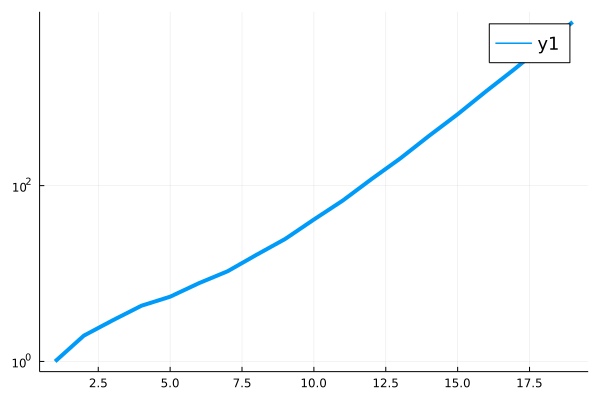

In [4]:
vcond(mat, points, nmax) = [cond(mat(points(-1, 1, n))) for n in 2:nmax]
plot([vcond(vander_legendre, LinRange, 20)], yscale=:log10)

## A different set of points

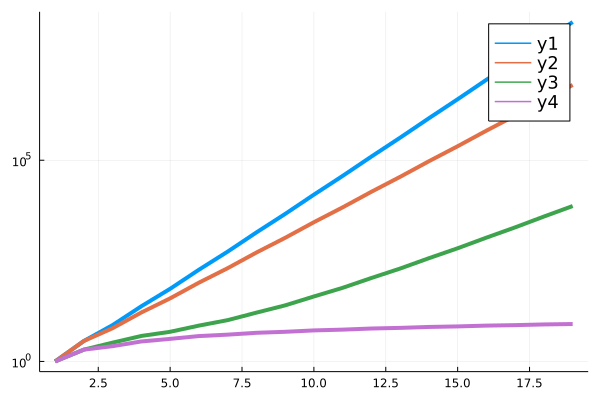

In [5]:
CosRange(a, b, n) = (a + b)/2 .+ (b - a)/2 * cos.(LinRange(-pi, 0, n))

plot([vcond(vander, LinRange, 20)], yscale=:log10)
plot!([vcond(vander, CosRange, 20)], yscale=:log10)
plot!([vcond(vander_legendre, LinRange, 20)], yscale=:log10)
plot!([vcond(vander_legendre, CosRange, 20)], yscale=:log10)

## What's wrong with ill-conditioning?

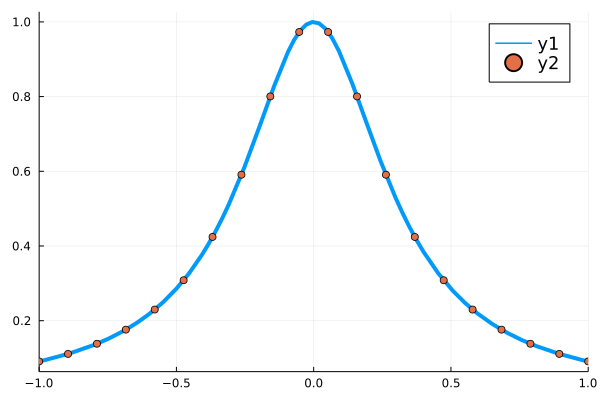

In [21]:
runge(x) = 1 / (1 + 10*x^2)

x = LinRange(-1, 1, 20) # try CosRange
y = runge.(x)
plot(runge, xlims=(-1, 1))
scatter!(x, y)

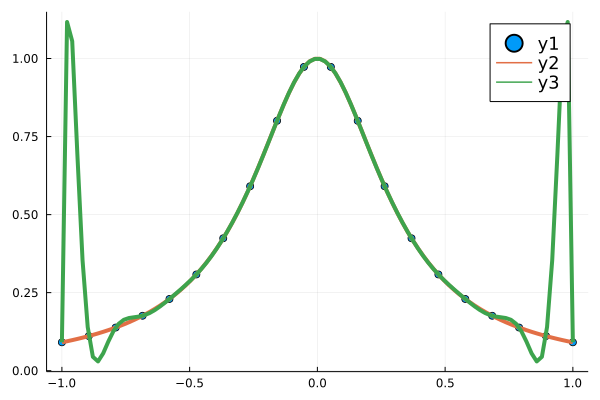

In [22]:
ourvander = vander # try vander_legendre
p = ourvander(x) \ y;
scatter(x, y)
s = LinRange(-1, 1, 100)
plot!(s, runge.(s))
plot!(s, ourvander(s, length(x)) * p)

In [8]:
cond(ourvander(s, length(x)) / ourvander(x))

4115.2853049797

In [9]:
cond(ourvander(x))

2.722408230241045e8

# Chebyshev polynomials

Define $$ T_n(x) = \cos (n \arccos(x)) .$$
This turns out to be a polynomial, but it's not obvious why.
Recall $$ \cos(a + b) = \cos a \cos b - \sin a \sin b .$$
Let $y = \arccos x$ and check
$$ \begin{split}
    T_{n+1}(x) &= \cos \big( (n+1) y \big) = \cos ny \cos y - \sin ny \sin y \\
    T_{n-1}(x) &= \cos \big( (n-1) y \big) = \cos ny \cos y + \sin ny \sin y
\end{split}$$
Adding these together produces
$$ T_{n+1}(x) + T_{n-1}(x) = 2\cos ny \cos y = 2 x \cos ny = 2 x T_n(x) $$
which yields a convenient recurrence:
$$\begin{split}
T_0(x) &= 1 \\
T_1(x) &= x \\
T_{n+1}(x) &= 2 x T_n(x) - T_{n-1}(x)
\end{split}$$

# Chebyshev polynomials
$$\begin{split}
T_0(x) &= 1 \\
T_1(x) &= x \\
T_{n+1}(x) &= 2 x T_n(x) - T_{n-1}(x)
\end{split}$$

In [10]:
function vander_chebyshev(x, n=nothing)
    if isnothing(n)
        n = length(x) # Square by default
    end
    m = length(x)
    T = ones(m, n)
    if n > 1
        T[:, 2] = x
    end
    for k in 3:n
        T[:, k] = 2 * x .* T[:,k-1] - T[:, k-2]
    end
    T
end

vander_chebyshev (generic function with 2 methods)

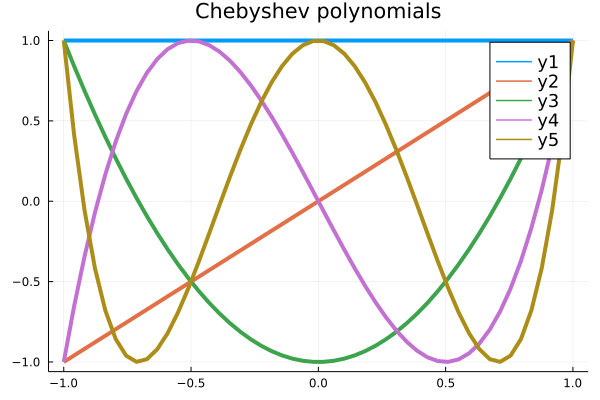

In [11]:
x = LinRange(-1, 1, 50)
plot(x, vander_chebyshev(x, 5), title="Chebyshev polynomials")

# Chebyshev polynomials are well-conditioned



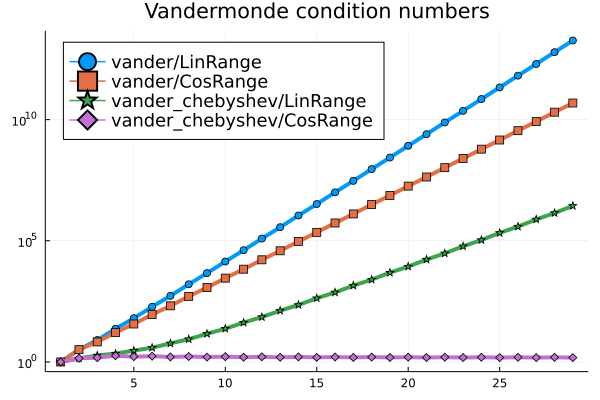

In [13]:
plot_vcond(mat, points) = plot!([
        cond(mat(points(-1, 1, n)))
        for n in 2:30], label="$mat/$points", marker=:auto, yscale=:log10)

plot(title="Vandermonde condition numbers", legend=:topleft)
plot_vcond(vander, LinRange)
plot_vcond(vander, CosRange)
plot_vcond(vander_chebyshev, LinRange)
plot_vcond(vander_chebyshev, CosRange)

# Lagrange interpolating polynomials revisited

Let's re-examine the Lagrange polynomials as we vary the points.

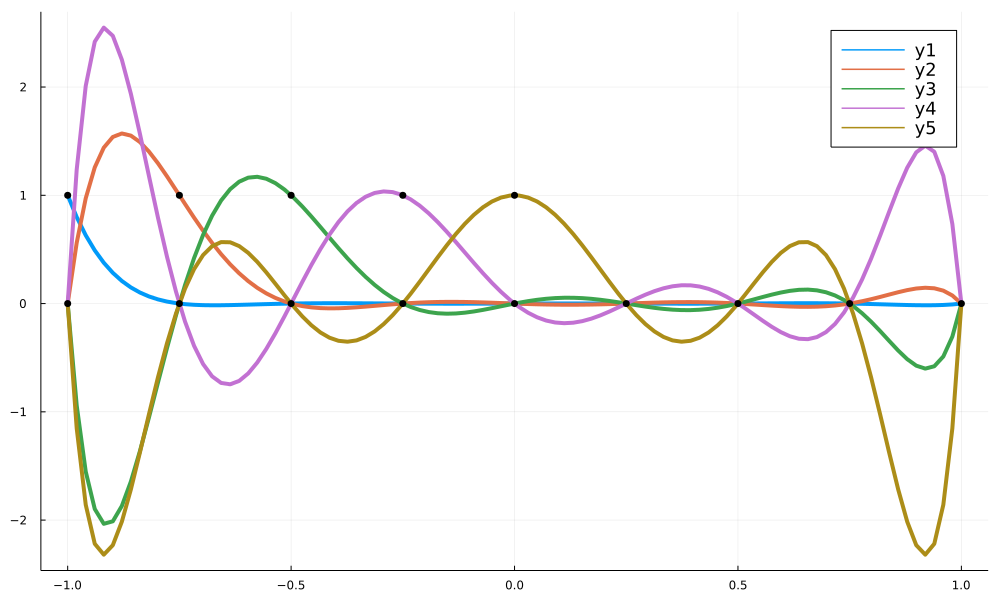

In [37]:
x = LinRange(-1, 1, 9) # CosRange?
s = LinRange(-1, 1, 100)
A = vander_chebyshev(s, length(x)) /
    vander_chebyshev(x)
plot(s, A[:,1:5], size=(1000, 600))
scatter!(x[1:5], ones(5), color=:black, label=nothing)
scatter!(x, zero(x), color=:black, label=nothing)

* Are there artifacts?

# Piecewise interpolation

In [17]:
function interp_nearest(x, s)
    A = zeros(length(s), length(x))
    for (i, t) in enumerate(s)
        loc = nothing
        dist = Inf
        for (j, u) in enumerate(x)
            if abs(t - u) < dist
                loc = j
                dist = abs(t - u)
            end
        end
        A[i, loc] = 1
    end
    A
end
interp_nearest(LinRange(-1, 1, 3), LinRange(0, 1, 4))

4×3 Matrix{Float64}:
 0.0  1.0  0.0
 0.0  1.0  0.0
 0.0  0.0  1.0
 0.0  0.0  1.0

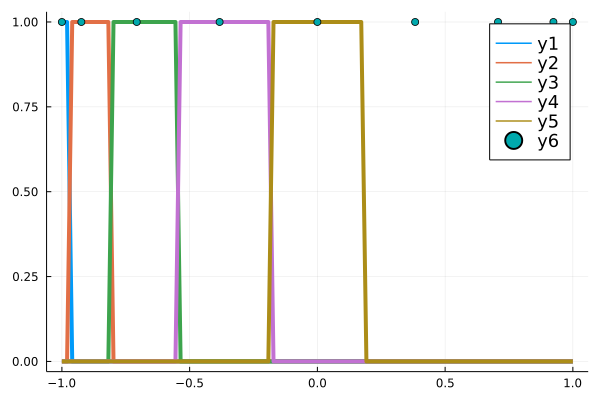

In [18]:
A = interp_nearest(x, s)
plot(s, A[:, 1:5])
scatter!(x, ones(length(x)))

## I don't see any visual artifacts


In [23]:
x = LinRange(-1, 1, 30)
A = interp_nearest(x, s)
cond(A)

1.414213562373095

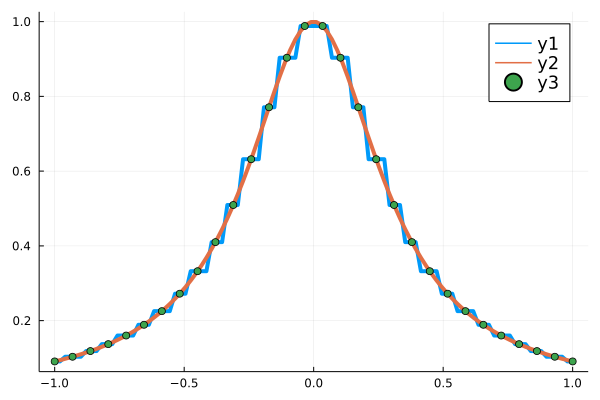

In [24]:
plot(s, A * runge.(x))
plot!(s, runge.(s))
scatter!(x, runge.(x))

In [31]:
function interp_chebyshev(x, xx)
    vander_chebyshev(xx, length(x)) * inv(vander_chebyshev(x))
end

function interp_monomial(x, xx)
    vander(xx, length(x)) * inv(vander(x))
end

function interp_error(ieval, x, xx, test)
    """Compute norm of interpolation error for function test
    using method interp_and_eval from points x to points xx.
    """
    A = ieval(x, xx)
    y = test.(x)
    yy = test.(xx)
    norm(A * y - yy, Inf)
end

function plot_convergence(ievals, ptspaces; xscale=:log10, yscale=:log10, maxpts=40)
    """Plot convergence rates for an interpolation scheme applied
    to a set of tests.
    """
    xx = LinRange(-1, 1, 100)
    ns = 2:maxpts
    fig = plot(title="Convergence",
        xlabel="Number of points",
        ylabel="Interpolation error",
        xscale=xscale,
        yscale=yscale,
        legend=:bottomleft,
        size=(1200, 800))
    for ieval in ievals
        for ptspace in ptspaces
            for test in [runge]
                errors = [interp_error(ieval, ptspace(-1, 1, n), xx, test)
                         for n in ns]
                plot!(ns, errors, marker=:circle, label="$ieval/$ptspace")
            end
        end
    end
    for k in [1, 2, 3]
        plot!(ns, ns .^ (-1.0*k), color=:black, label="\$n^{-$k}\$")
    end
    fig
end


plot_convergence (generic function with 1 method)

# So maybe it's not that accurate?


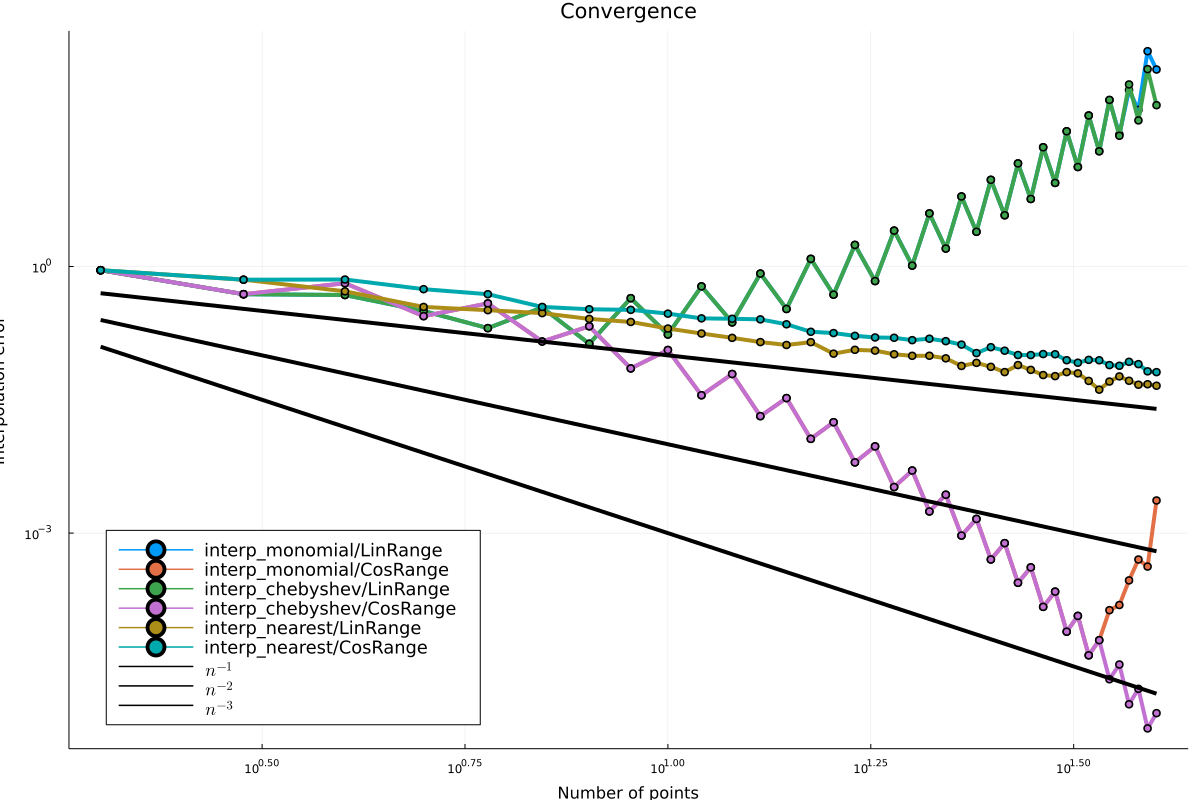

In [32]:
plot_convergence([interp_monomial, interp_chebyshev, interp_nearest], [LinRange, CosRange])